# Zindi ARC Competition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install numpy pandas matplotlib transformers accelerate -qqq

# Libs

In [202]:
import csv

from datetime import datetime

import numpy as np

import os.path as osp

import pandas as pd
from pathlib import Path
from pprint import pprint

import random

import sys
sys.path.append("../")

import time
from tqdm.auto import tqdm
import torch

In [186]:
from src.config import Config
from src.utils import (load_data, 
                        sample_arc_task,
                        plot_random,
                        visualize_task, 
                        reconstruct_grids, 
                        get_grid_shape,
                        get_row_sizes,
                        infer_out_shape)
from src.model import ARCModel

# Dataset

In [5]:
train_data, test_data = load_data(data_path=Config.data_path)

print(f"✓ Loaded {len(train_data)} training problems")
print(f"✓ Loaded {len(test_data)} test problems")

✓ Loaded 746 training problems
✓ Loaded 185 test problems


In [128]:
example_task_id, example_task = sample_arc_task(test_data, split=None)

test_output = example_task["test"][0]["output"] if "output" in example_task["test"][0].keys() else None

print(f"Sampled task: {example_task_id}")

Sampled task: test_0169


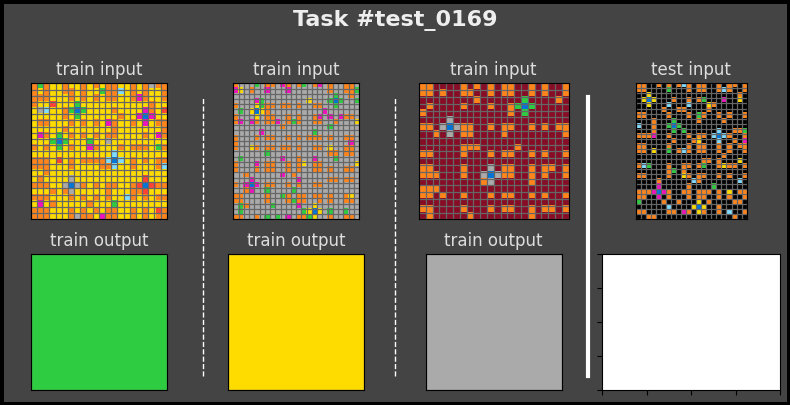

In [129]:
#visualize_task(task_data=train_data["train_0289"],task_id="train_0289", size=2.0, w1=.9)
visualize_task(task_data=example_task,task_id=example_task_id, size=2.0, w1=.9)

In [51]:
for _ in range(50):
    example_task_id, example_task = sample_arc_task(train_data, split=None)
    print(f"Sampled task: {example_task_id}")

    test_in = example_task["test"][0]["input"]
    test_in_shape = get_grid_shape(test_in)
    print("Input shape: \t", test_in_shape)
    
    num_rows = len(example_task["test"][0]["output"]) if "output" in example_task["test"][0].keys() else None
    
    inferred_out_shape = infer_out_shape(
        train_pairs=example_task["train"], 
        test_input=test_in,
        expected_rows=num_rows
    )

    print("Predicted: \t", inferred_out_shape)

    if num_rows is not None:
        test_out_shape = get_grid_shape(example_task["test"][0]["output"])
        print("Actual: \t", test_out_shape)
        print("Match: \t", inferred_out_shape == test_out_shape)

    print()

Sampled task: train_0670
Input shape: 	 (10, 10)
[INFO] Input and output shapes are identical in all pairs
Predicted: 	 (10, 10)
Actual: 	 (10, 10)
Match: 	 True

Sampled task: train_0432
Input shape: 	 (18, 18)
[INFO] Fallback 1: Looking for constant scaling between input and output
[INFO] Inconsistency detected...exploring other options.
[INFO] Fallback 2: Test input shape matches a training input shape exactly
Predicted: 	 (18, 5)
Actual: 	 (18, 5)
Match: 	 True

Sampled task: train_0331
Input shape: 	 (13, 13)
[INFO] Input and output shapes are identical in all pairs
Predicted: 	 (13, 13)
Actual: 	 (13, 13)
Match: 	 True

Sampled task: train_0677
Input shape: 	 (10, 10)
[INFO] Input and output shapes are identical in all pairs
Predicted: 	 (10, 10)
Actual: 	 (10, 10)
Match: 	 True

Sampled task: train_0159
Input shape: 	 (25, 25)
[INFO] Input and output shapes are identical in all pairs
Predicted: 	 (25, 25)
Actual: 	 (25, 25)
Match: 	 True

Sampled task: train_0171
Input shape: 	 

# Model

In [134]:
%%time

base_prompt_path = "../src/base_prompt.txt"
model = ARCModel(
    system_prompt_path=base_prompt_path, 
    base_llm_name=None,
    verbose=False
)


CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 5.96 μs


In [137]:
%%time

preds = model.solve(example_task)

CPU times: user 18 μs, sys: 1e+03 ns, total: 19 μs
Wall time: 19.8 μs


In [138]:
task_solutions = {
    f"{example_task_id}": preds
}

task_solutions

{'test_0169': [[7]]}

In [139]:
if test_output:
    pprint(test_output)
    metrics = model.evaluate(example_task, preds)
    print(metrics)

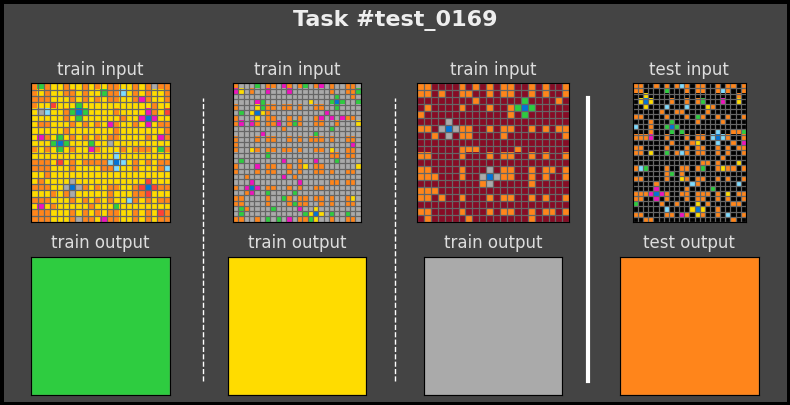

In [140]:

visualize_task(
    task_data=example_task,task_id=example_task_id, size=2.0, w1=.9, task_solutions=task_solutions)

# Run on Training Set

In [183]:
total_match = 0
total_pix_acc = 0
train_preds = []

for task_id in train_data.keys():
    task = train_data[task_id]
    pred = model.solve(task)
    train_preds.append(pred)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()

    total_match+=match
    total_pix_acc+=pix_acc

avg_acc = total_match/len(train_data)
avg_pix_acc = total_pix_acc/len(train_data)

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

1.74263% correct matches with 60.28119% pixel acc


# Run on Test Set

In [185]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join(Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [213]:
ss

,ID,row
0,test_0000_1,0000000000
1,test_0000_2,0000000000
2,test_0000_3,0000000000
3,test_0000_4,0000000000
4,test_0000_5,0000000000
...,...,...
2298,test_0184_6,0000000000
2299,test_0184_7,0000000000
2300,test_0184_8,0000000000
2301,test_0184_9,0000000000


In [191]:
test_out_rows = get_row_sizes(ss)
test_out_rows

,ID_,n_rows
0,test_0000,10
1,test_0001,12
2,test_0002,10
3,test_0003,8
4,test_0004,30
...,...,...
180,test_0180,25
181,test_0181,10
182,test_0182,19
183,test_0183,10


In [192]:
test_out_rows.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_rows,185.0,12.448649,7.509328,1.0,8.0,10.0,16.0,30.0


In [190]:
len(test_data.keys())

185

In [198]:
test_preds = []

for task_id, n_out_rows in zip(test_data.keys(), test_out_rows.n_rows.values):
    task = test_data[task_id]
    pred = model.solve(task, n_out_rows)
    test_preds.append(pred)

In [223]:
date_str = datetime.now().strftime("%Y-%m-%d")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}"

out_path = osp.join(Config.submission_path, sub_filename)

generate_submission(
    model, 
    test_data, 
    expected_rows_list=test_out_rows.n_rows.values, 
    output_path=out_path
)

✅ Submission saved to ../submissions/2025-07-29-submission-simple-arc-solver-cp-baseline-cp


In [224]:
submision = pd.read_csv(out_path)

In [225]:
submision

,ID,row
0,test_0000_1,7777777777
1,test_0000_2,7557775557
2,test_0000_3,7757777757
3,test_0000_4,7577777577
4,test_0000_5,7555775555
...,...,...
2298,test_0184_6,7787533335333777777
2299,test_0184_7,7787537775783777777
2300,test_0184_8,7787537775783777777
2301,test_0184_9,7787555555783777777


In [226]:
submision.shape == ss.shape

True

In [229]:
sum(submision.ID == ss.ID)/ ss.shape[0]

1.0

In [230]:
predictions = reconstruct_grids(submision)

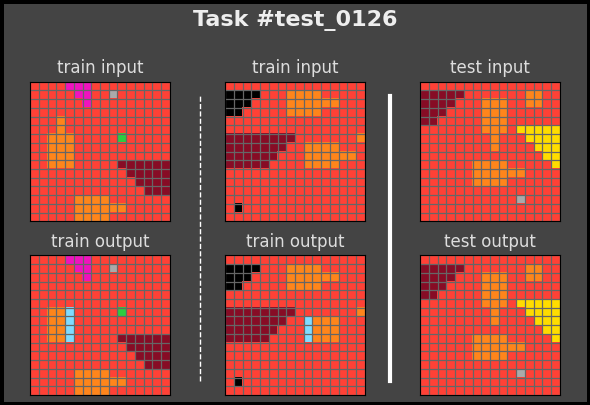

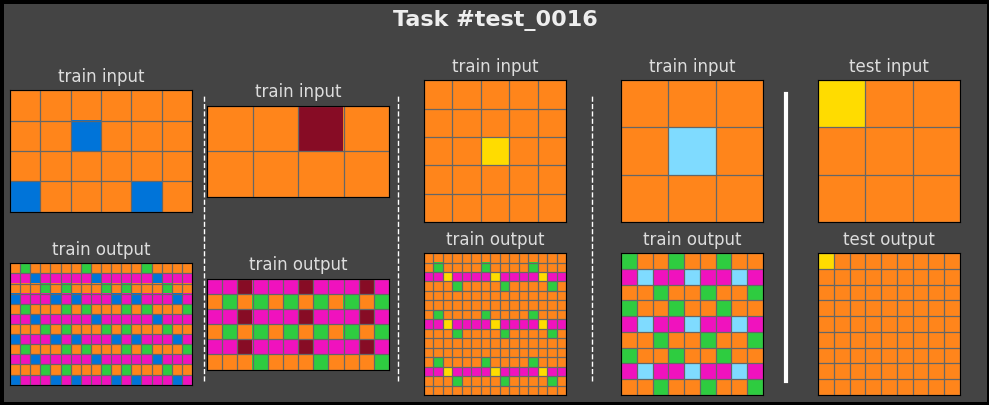

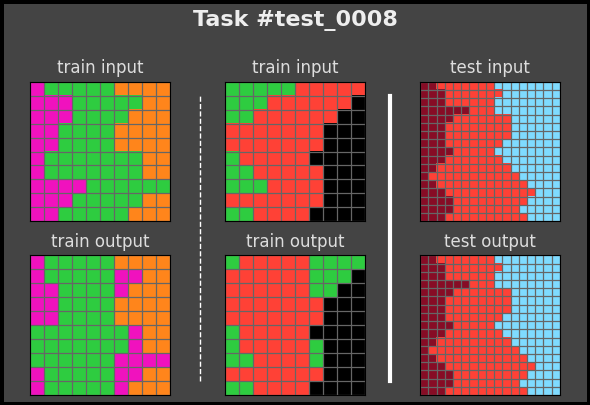

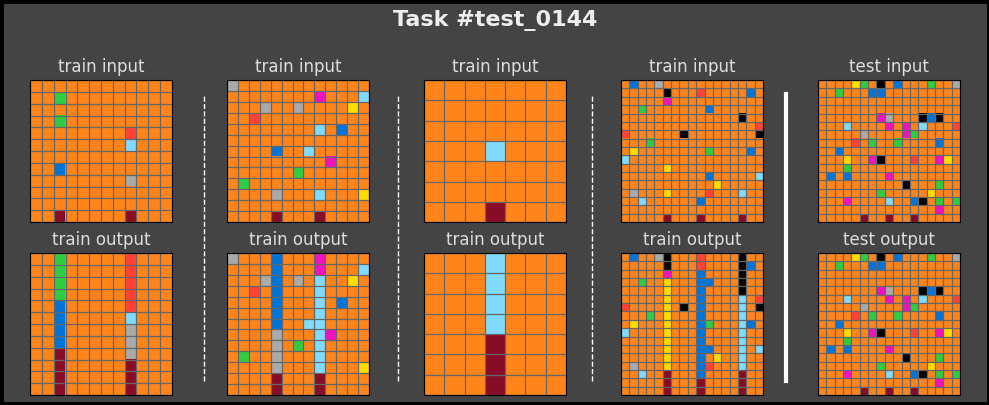

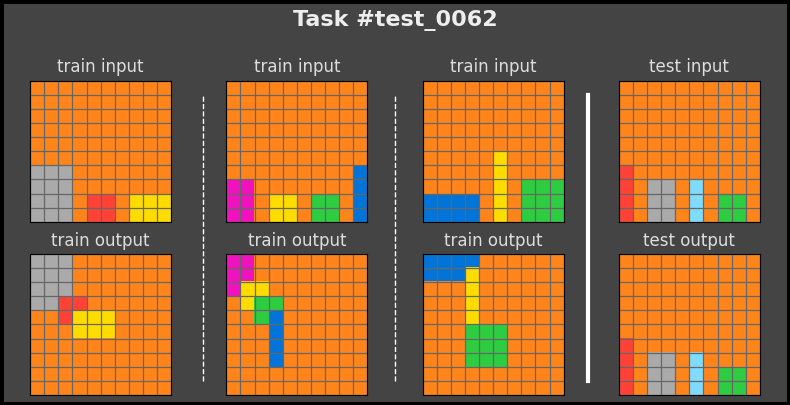

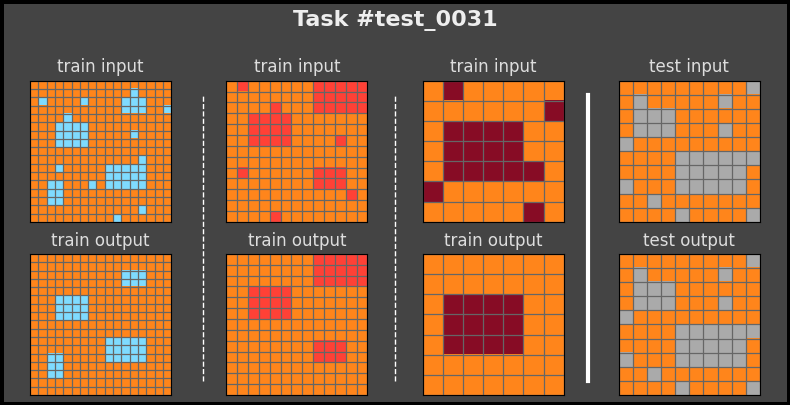

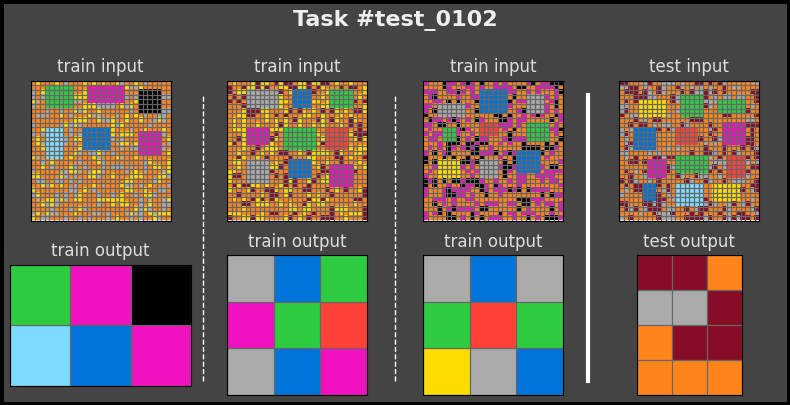

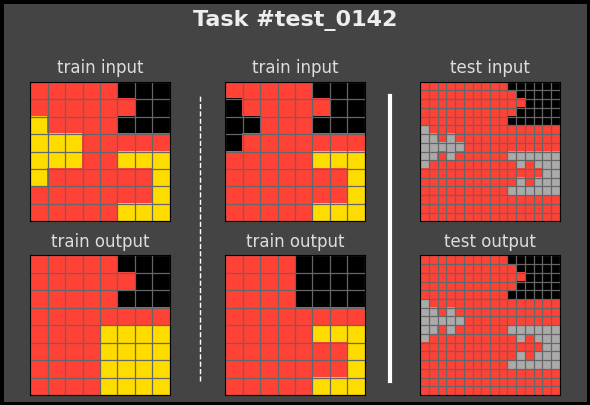

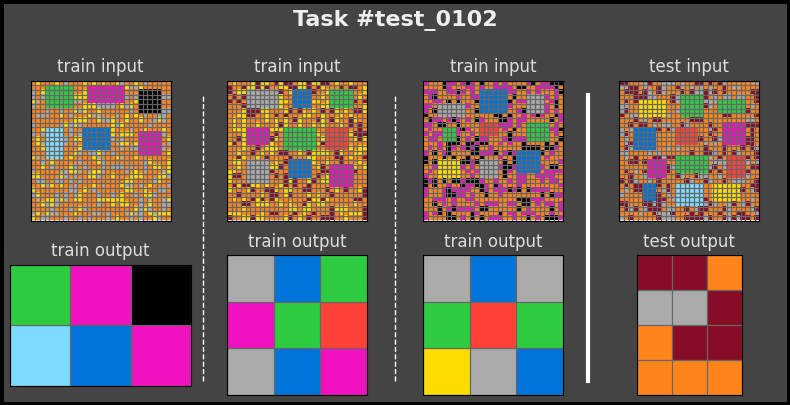

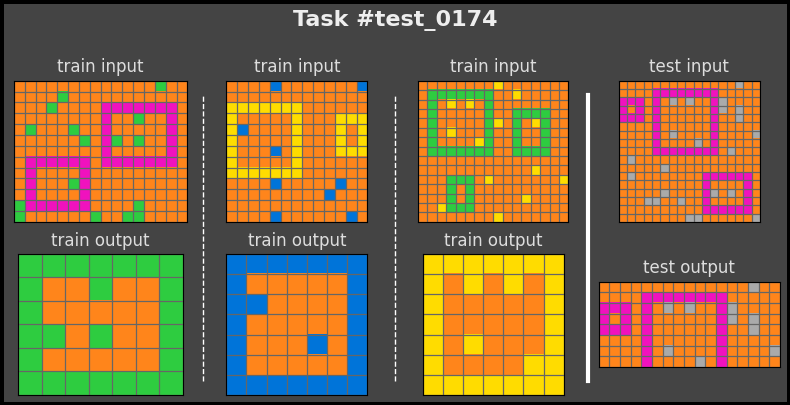

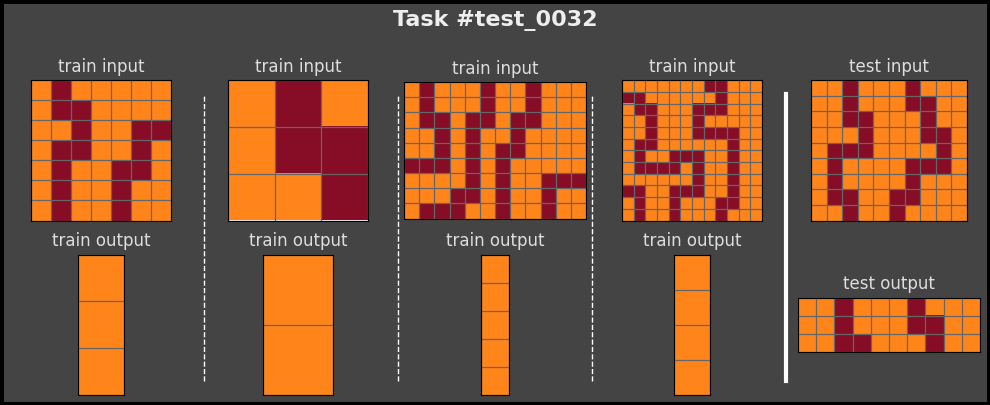

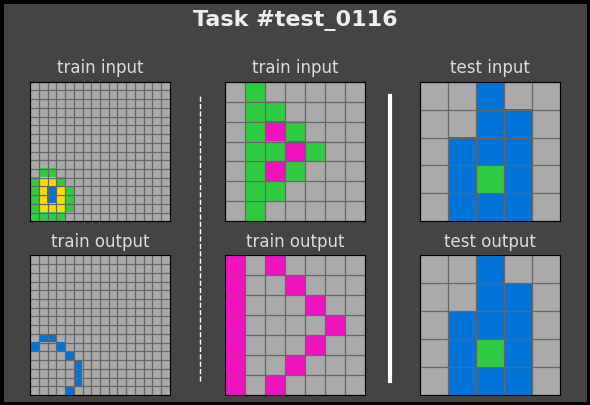

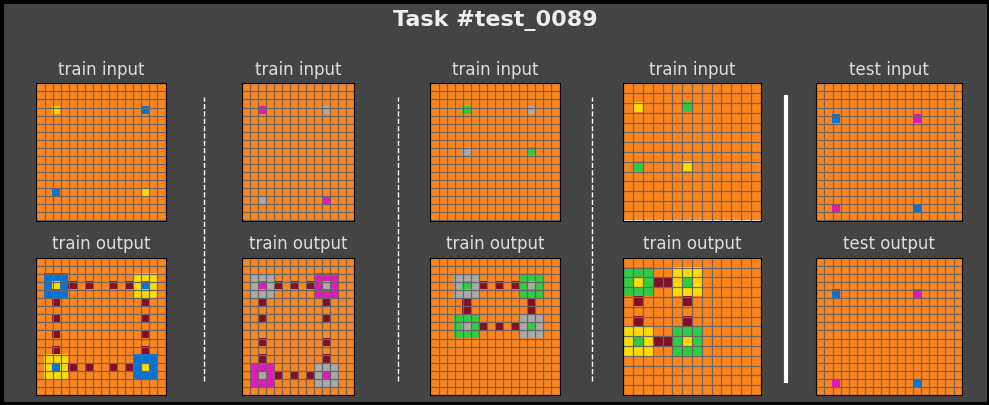

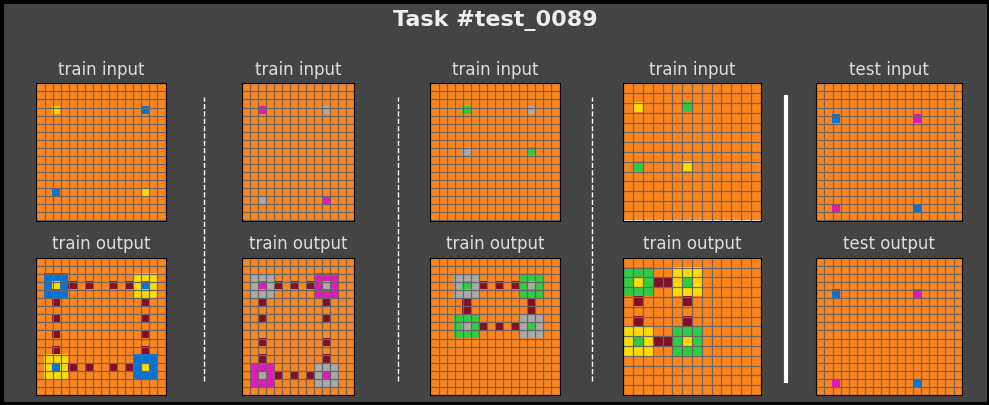

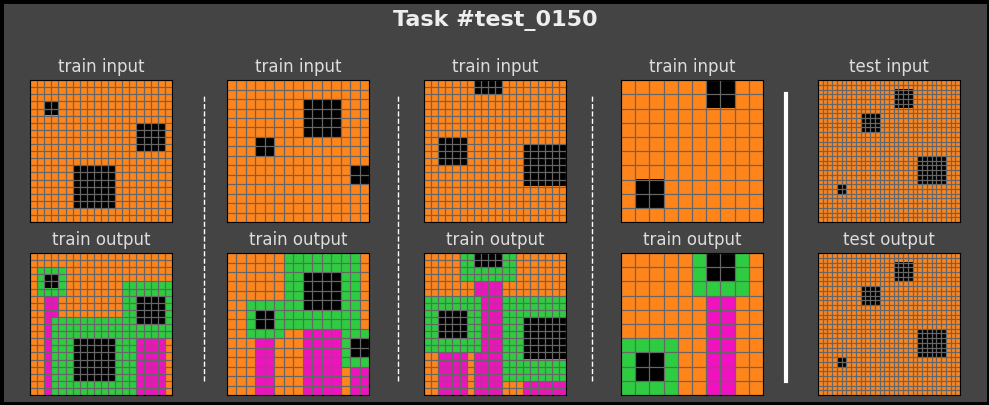

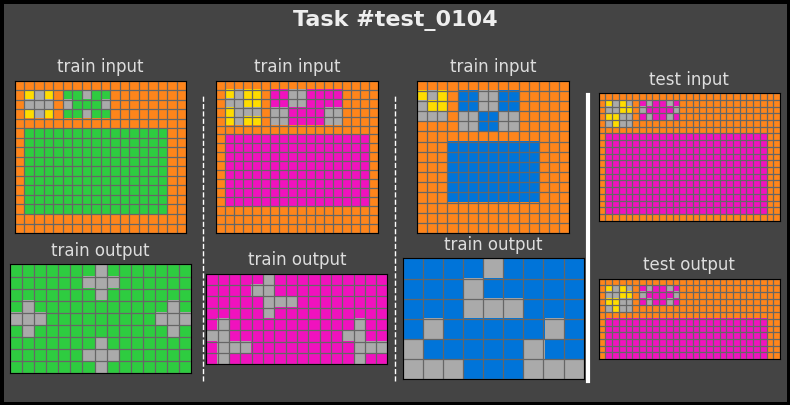

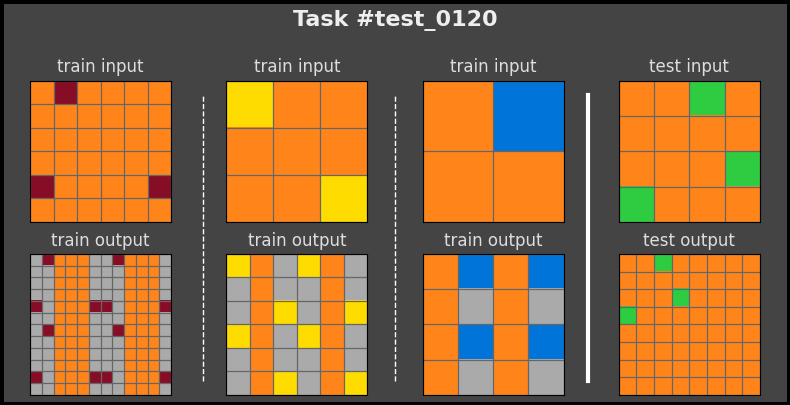

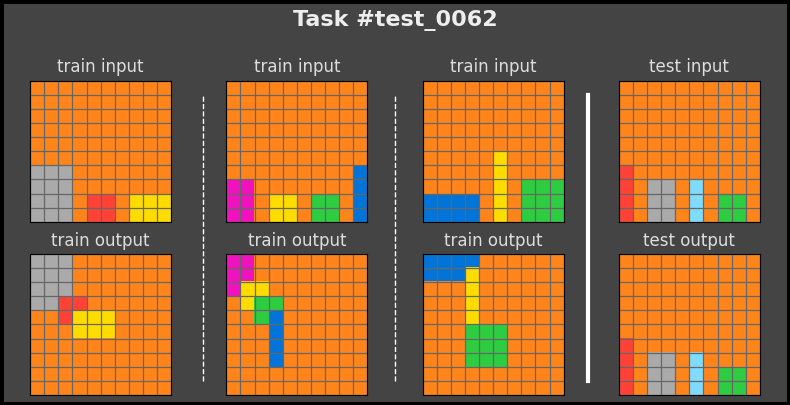

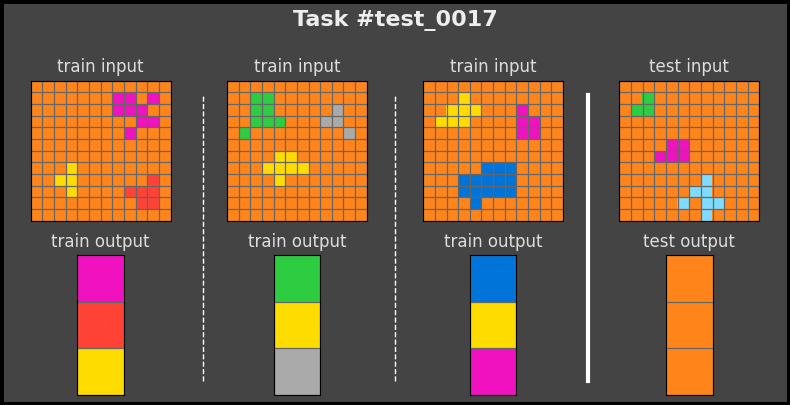

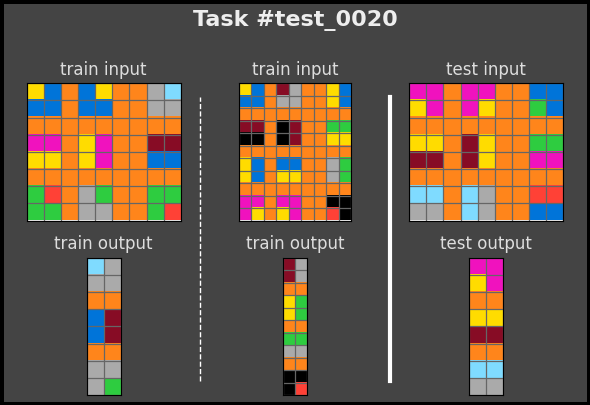

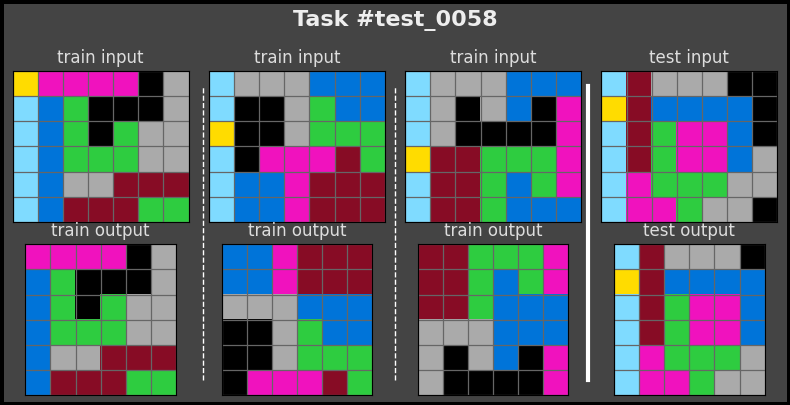

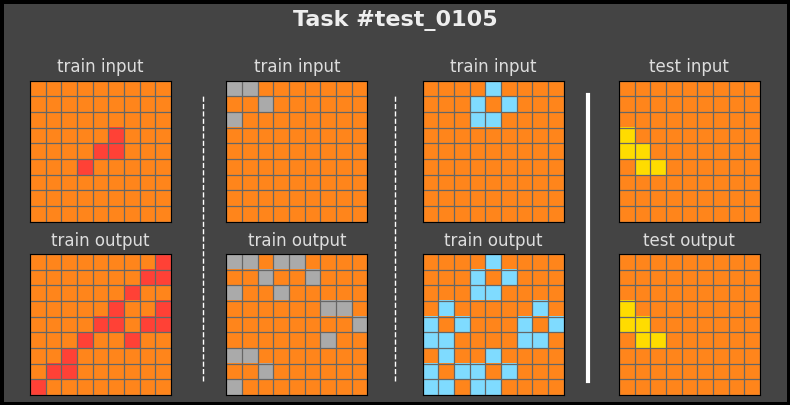

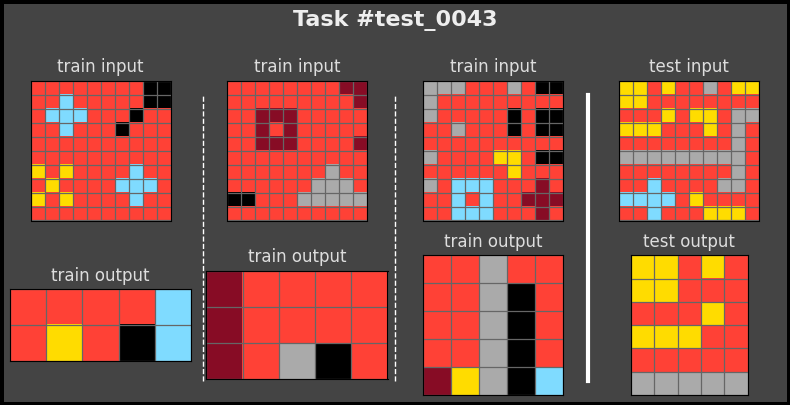

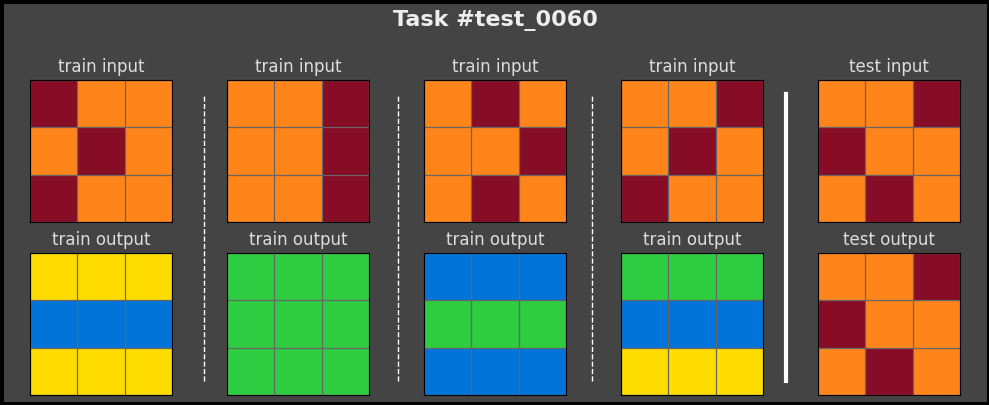

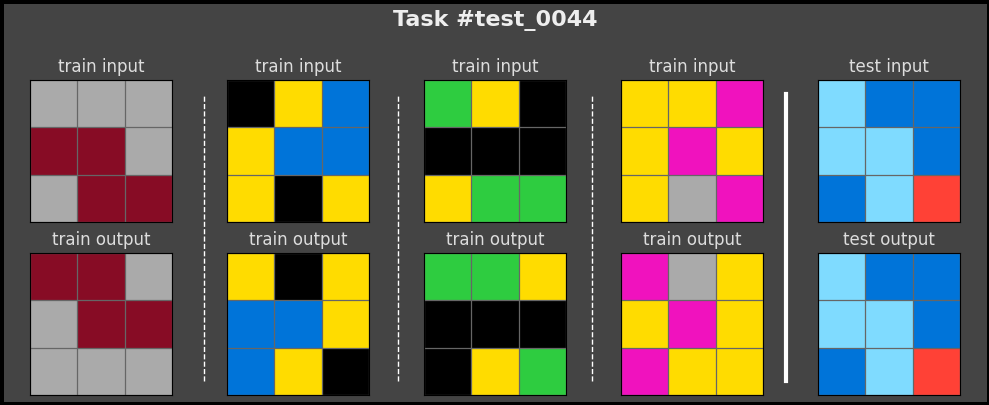

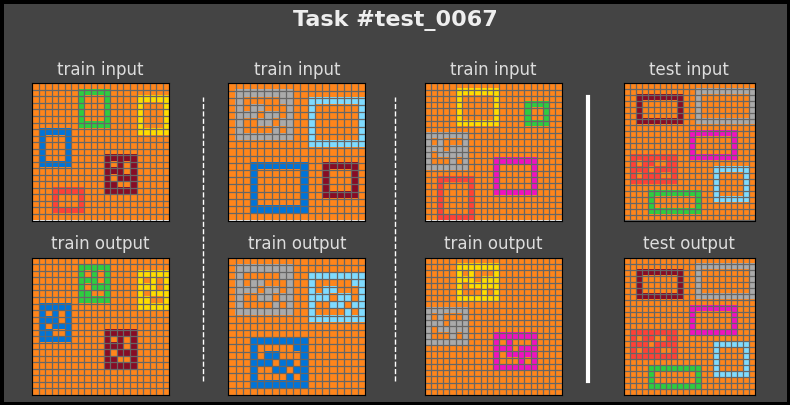

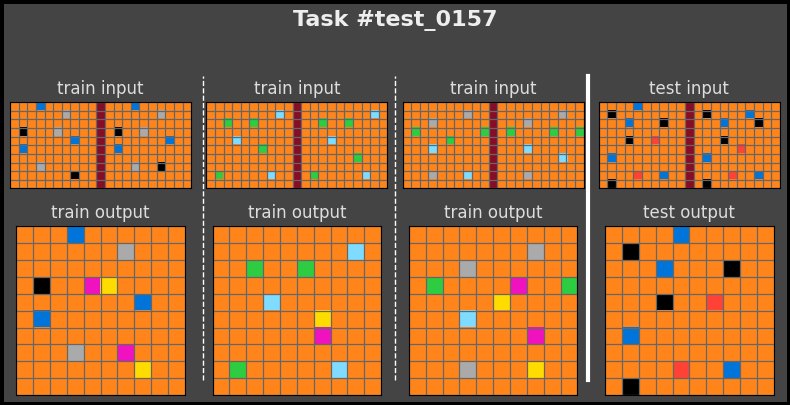

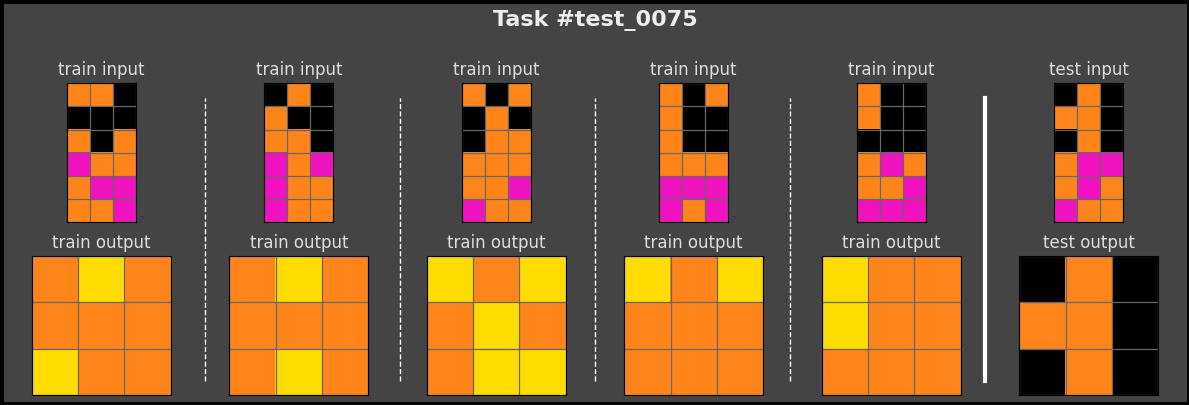

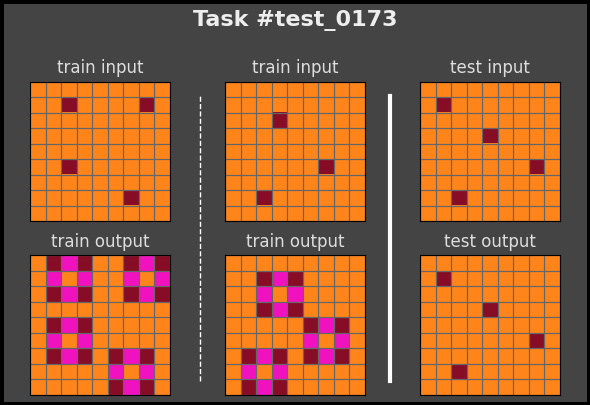

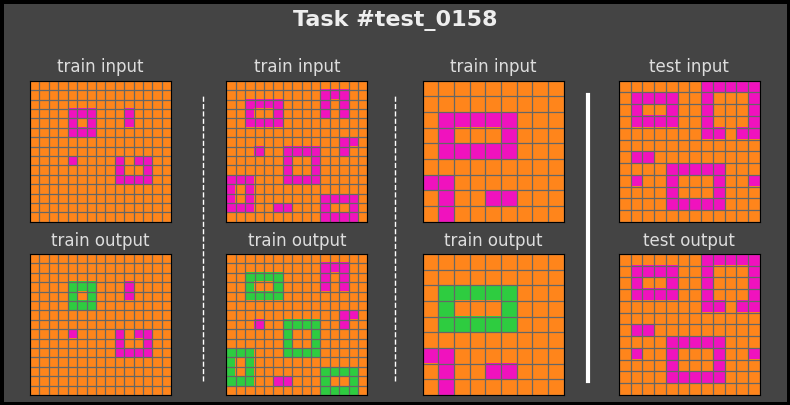

In [232]:
for i in range(30):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)